In [22]:
# %matplotlib widget
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from qokit.parameter_utils import get_fixed_gamma_beta

# rc('font',**{'family':'serif','serif':['Times New Roman'],'size':16})
# rc('text', usetex=True)

method = "LN_COBYLA (NLopt)"
problem = "po"
p = 1
n = 20
seed_pool = list(range(60)) if problem == "po" else list(range(1000))

data = pickle.load(
    open(
        f"data/{problem}/configs/max_ar/LN_COBYLA (NLopt)-p{p}-q{n}-s0-{59 if problem == 'po' else 999}.pckl",
        "rb",
    ),
)
gamma, beta = get_fixed_gamma_beta(3, p)
optimal_params = data["optimal_params"]# - np.concatenate([gamma, [b * 4 for b in beta]])
max_ar = data["result"][:len(seed_pool),np.newaxis,np.newaxis]

data = pickle.load(
    open(
        f"data/{problem}/configs/budget/{method}-p{p}-q{n}-s{seed_pool[0]}-{seed_pool[-1]}.pckl",
        "rb",
    ),
)
config = data["config"]
result = data["result"][:,:,:]
initial_ar = np.array(data["initial_ar"])[:,np.newaxis,np.newaxis]

print(config, result.shape)
shots_pool = [d["shots"] for d in config["executor_kwargs"]][:]
maxfev_pool = config["maxeval"][:]


{'initial_point': [array([ 2.        , -3.14159265])], 'maxeval': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50], 'initial_step': [1.0], 'ftol_rel': [1e-13], 'executor_kwargs': [{'shots': 2500}, {'shots': 2000}, {'shots': 1666}, {'shots': 1428}, {'shots': 1250}, {'shots': 1111}, {'shots': 1000}, {'shots': 909}, {'shots': 833}, {'shots': 769}, {'shots': 714}, {'shots': 666}, {'shots': 625}, {'shots': 588}, {'shots': 555}, {'shots': 526}, {'shots': 500}, {'shots': 400}, {'shots': 333}, {'shots': 285}, {'shots': 250}, {'shots': 222}, {'shots': 200}]} (60, 23, 23)


In [23]:
result = (result - initial_ar) / (max_ar - initial_ar)
# result = result[((max_ar - initial_ar) < 0.05).flat]
print(result.shape)

print((initial_ar.flatten() - max_ar.flatten())[:10])
print(np.sort((max_ar - initial_ar).flat)[-1:-6:-1])


(60, 23, 23)
[-0.09720353 -0.03567271 -0.06617001 -0.03993252 -0.03159112 -0.04284859
 -0.06831946 -0.10745661 -0.04103804 -0.03505934]
[0.1479462  0.12305627 0.12088954 0.11481734 0.11446527]


Text(0.5, 1.0, 'po p=1 n=20')

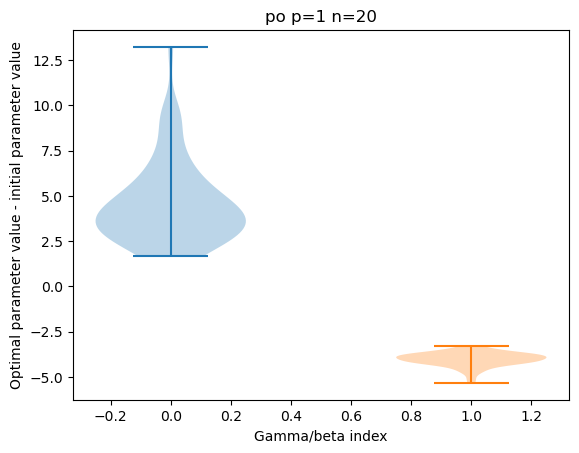

In [24]:
plt.figure()
for i in range(2 * p):
    plt.violinplot(optimal_params[:,i], [i])
# plt.ylim(0, np.pi)
plt.ylabel("Optimal parameter value - initial parameter value")
plt.xlabel("Gamma/beta index")
plt.title(f"{problem} {p=} {n=}")


In [25]:
# print("Initial AR:", np.mean(initial_ar))
mean_ar = np.mean(result, axis=0)
indices = np.argsort(mean_ar.flat)[-1:-100:-1]
for r, c in zip(mean_ar.flatten()[indices], config.interpret(indices)):
    print(r, c)


0.9297558968878111 ['maxeval=20', "executor_kwargs={'shots': 2500}"]
0.9246527469326877 ['maxeval=20', "executor_kwargs={'shots': 2000}"]
0.9187888744748433 ['maxeval=13', "executor_kwargs={'shots': 2500}"]
0.9187779941468827 ['maxeval=35', "executor_kwargs={'shots': 2500}"]
0.9112872202159004 ['maxeval=30', "executor_kwargs={'shots': 1666}"]
0.9101683942625455 ['maxeval=11', "executor_kwargs={'shots': 1666}"]
0.9100406277760507 ['maxeval=45', "executor_kwargs={'shots': 2000}"]
0.9091931962245611 ['maxeval=9', "executor_kwargs={'shots': 2500}"]
0.9071571035640361 ['maxeval=10', "executor_kwargs={'shots': 1666}"]
0.9046499044713662 ['maxeval=25', "executor_kwargs={'shots': 2500}"]
0.9036295733863954 ['maxeval=30', "executor_kwargs={'shots': 2500}"]
0.9024203308036037 ['maxeval=17', "executor_kwargs={'shots': 2000}"]
0.9007340689600468 ['maxeval=30', "executor_kwargs={'shots': 2000}"]
0.8977511337516131 ['maxeval=10', "executor_kwargs={'shots': 2000}"]
0.8965057312773044 ['maxeval=35', "

Text(0.5, 0, 'relative AR improvement')

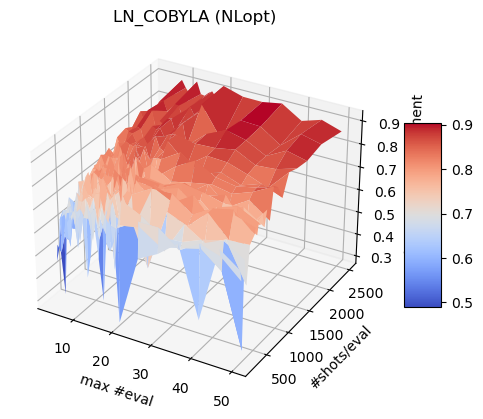

In [26]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(maxfev_pool, shots_pool, indexing='ij')
z = np.mean(result, axis=0)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
# ax.plot_surface(x, y, np.ones_like(z) * np.mean(initial_ar), cmap=cm.coolwarm, linewidth=0, antialiased=True, rstride=1, cstride=1, edgecolor='none')
ax.set_title(method)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_ylabel('#shots/eval')
ax.set_xlabel('max #eval')
ax.set_zlabel('relative AR improvement')
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}-3d.png")


Text(0.5, 1.0, 'po p=1 n=20')

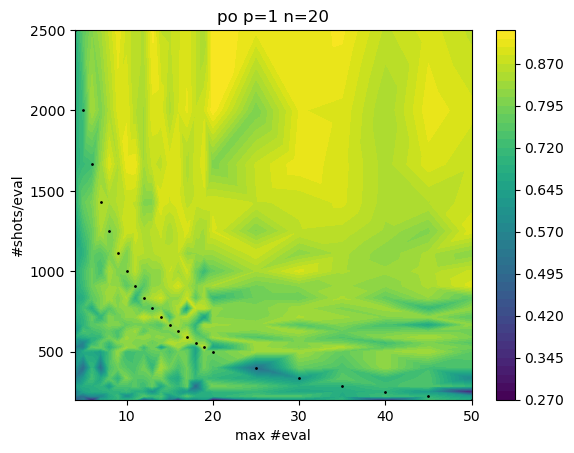

In [27]:
budget = 10000

plt.figure()
x, y = np.meshgrid(maxfev_pool, shots_pool, indexing='ij')
z = np.mean(result, axis=0)
fig = plt.tricontourf(x.flat, y.flat, z.flat, levels=50)
plt.plot(maxfev_pool, budget / np.array(maxfev_pool), "ko", ms=1)
plt.colorbar(fig)
plt.xlabel('max #eval')
plt.ylabel('#shots/eval')
plt.title(f"{problem} {p=} {n=}")
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}.png")


Text(0.5, 1.0, 'po p=1 n=20')

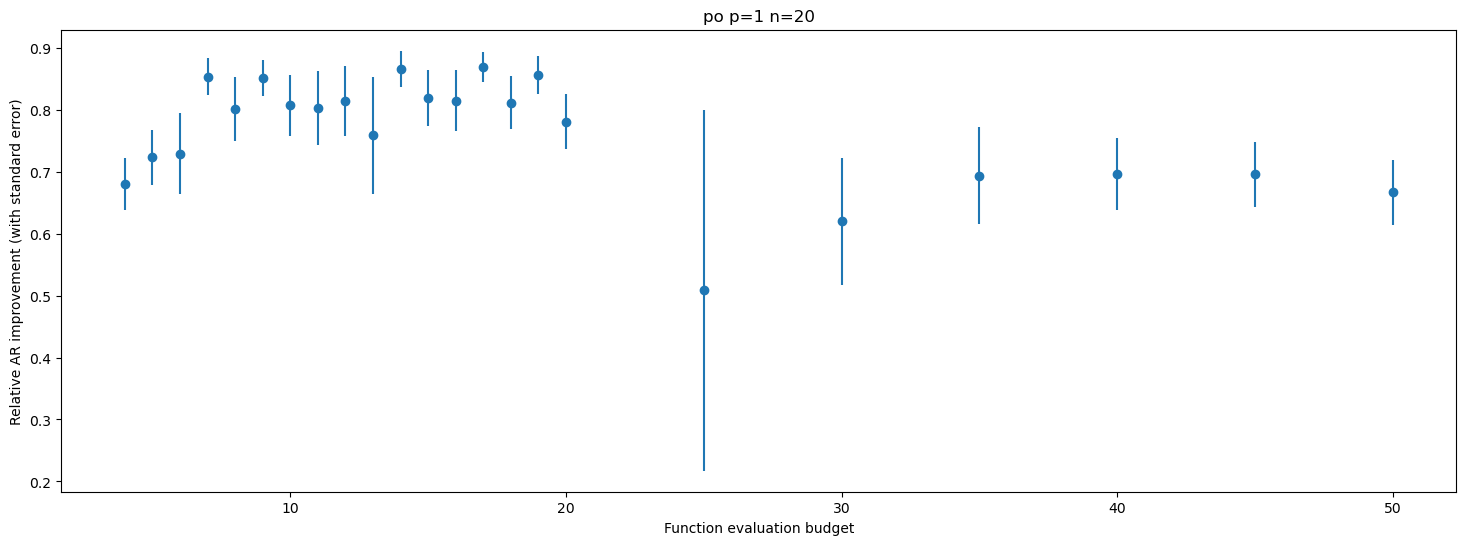

In [28]:
plt.figure(figsize=(18, 6))
# plt.violinplot(
#     [result[:, j, j] for j in range(len(shots_pool))],
#     maxfev_pool,
#     widths=1,
#     showmeans=True,
#     quantiles=[[0.25, 0.75]] * len(shots_pool),
# )
# plt.ylim([0, 1])
plt.errorbar(
    maxfev_pool,
    [np.mean(result, axis=0)[i, i] for i in range(len(shots_pool))],
    yerr=[np.std(result[:, i, i]) / np.sqrt(result.shape[0]) for i in range(len(shots_pool))],
    fmt="o",
)
plt.ylabel("Relative AR improvement (with standard error)")
plt.xlabel("Function evaluation budget")
plt.title(f"{problem} {p=} {n=}")
# plt.savefig(f"figs/{problem}/budget/{method}-p{p}-q{n}-slice.png")


21
6
9
8
5
2
1
4
1
1


ValueError: zero-size array to reduction operation minimum which has no identity

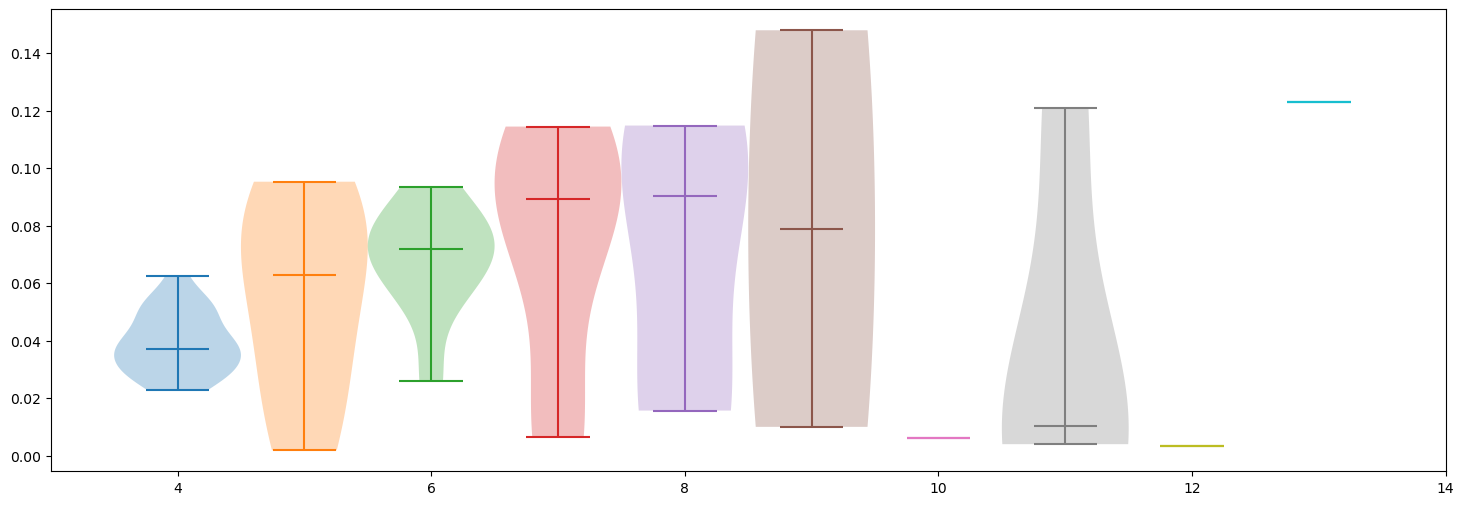

In [29]:
plt.figure(figsize=(18, 6))
for i, fev in enumerate(maxfev_pool):
    slice = np.array([result[:, j, j] for j in range(len(shots_pool))])
    ar_diff = (max_ar - initial_ar).flat[
        np.argmax(slice >= slice.max(axis=0) * 0.9, axis=0) == i
    ]
    plt.violinplot(
        ar_diff,
        [fev],
        widths=1,
        showmedians=True,
        # quantiles=[[0.25, 0.75]],
    )
    # plt.plot(
    #     fev,
    #     np.median(ar_diff),
    #     # yerr=np.std(ar_diff) / np.sqrt(len(ar_diff)),
    #     label=f"{fev=}",
    #     # fmt="o",
    #     marker="o"
    # )
    print(len(ar_diff))
    if i == len(maxfev_pool) - 1:
        print(ar_diff)
        print(slice.T[np.argmax(slice >= slice.max(axis=0), axis=0) == i])
plt.ylabel("AR range")
plt.xlabel("Function evaluation budget")
plt.title(f"{problem} {p=} {n=}")
# plt.ylim([0, 0.06])


Text(0, 0.5, 'AR range')

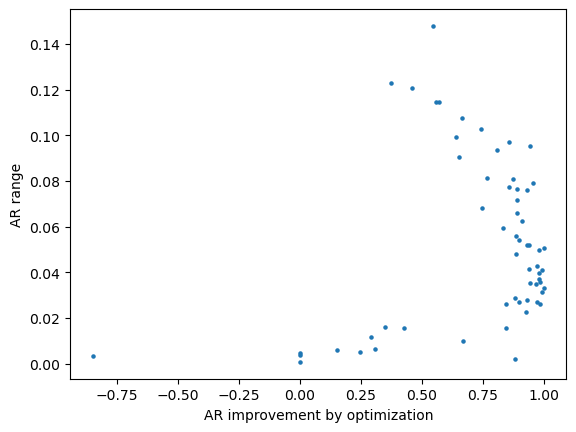

In [30]:
plt.figure()
plt.scatter(result[:60,1,1], (max_ar - initial_ar).flat[:60], s=5)
plt.xlabel("AR improvement by optimization")
plt.ylabel("AR range")


In [34]:
sorted_seeds = np.argsort(result[:,1,1])[-1::-1]
selected_seeds = sorted_seeds
# selected_seeds = sorted_seeds[np.isin(sorted_seeds, np.arange(1000)[np.where(np.abs((max_ar - initial_ar).flatten() - 0.05) < 0.015)])]
print(selected_seeds)
print(result[selected_seeds,1,1])
print((max_ar - initial_ar).flat[selected_seeds])


[40 54  8  4  1 42 59 48  3 43  5  9 15 17 23 41 19 56 52 28 32 49 18 50
 46 16  2 26 57 27 33 45  0 10 34 36 53 38 31  6 20 58  7 13 39 11 47 12
 37 21 55 24 30 14 29 22 25 35 51 44]
[ 0.99938004  0.99854235  0.99426223  0.99174796  0.98542882  0.98493435
  0.98103537  0.97925257  0.97916976  0.97369714  0.97040739  0.96648571
  0.95571943  0.94444226  0.94289794  0.94067616  0.93726346  0.93207539
  0.93042068  0.92944073  0.92474936  0.91103276  0.89831646  0.89790132
  0.89171059  0.88977306  0.88793157  0.88636865  0.88503488  0.88212212
  0.8804564   0.87544497  0.8560422   0.85510189  0.84604724  0.84493257
  0.83343305  0.80682888  0.7668442   0.74506098  0.74214725  0.66758937
  0.66491562  0.65049107  0.63779943  0.56864134  0.55588241  0.54647529
  0.46143171  0.42628504  0.37451403  0.34767911  0.30759021  0.29092083
  0.24620856  0.1509663   0.          0.          0.         -0.84860959]
[0.03331432 0.05051253 0.04103804 0.03159112 0.03567271 0.02635517
 0.03708824 0.0496

In [32]:
print(np.argsort(result[:,0,0] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,1,1] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,2,2] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,3,3] - initial_ar.flat)[-1:-10:-1])
print(np.argsort(result[:,4,4] - initial_ar.flat)[-1:-10:-1])


[ 5  4 57  3  8  1 54 59 50]
[ 5  4  8  3 17 48 15  1 54]
[ 5 38  4 57 10 49 17  8  0]
[38 17 39  2  5  3  0  6 20]
[ 0 11  7 39 17  5 10 38  2]


ValueError: x and y must be the same size

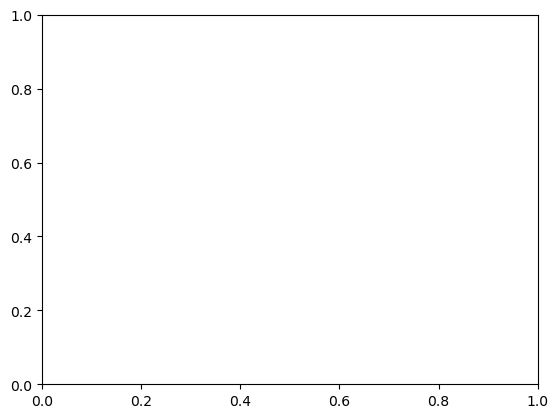

In [33]:
plt.figure()
plt.scatter(range(1000), np.sort((max_ar - initial_ar).flat), s=5)


In [ ]:
xx = [11, 12, 14, 16, 20]
yy = [900, 800, 700, 600, 500]
zz = [z[0,7], z[2,6], z[4,5], z[8,4]]
zz = [z[0,8], z[1,7], z[3,6], z[5,5], z[9,4]]
zz = [z[i, i] for i in range(len(shots_pool))]
print(zz)


[0.1641994701218559, 0.1498850872342797, 0.13063953189897473, 0.13565727958185284, 0.11402204952509432, 0.11840735918195203, 0.08916160798395661, 0.10388720043365811, 0.06953981248694684, 0.06766277222210025, 0.060385457007876606, 0.04753195131317291]
